# Compare with chromVAR: Part I

Since we completely re-implemented the algorithm proposed in [chromVAR](https://www.nature.com/articles/nmeth.4401) in Python, 
we may want to confirm that these two packages can produce the similar, if not exactly same, results. So here we test them on a small example data from chromVAR.

## Run chromVAR on example data

We first load the packages that we need

In [1]:
suppressMessages(library(chromVAR))
suppressMessages(library(Repitools))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(motifmatchr))
suppressMessages(library(Matrix))
suppressMessages(library(BiocParallel))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg19))
suppressMessages(library(JASPAR2020))
suppressMessages(library(TFBSTools))
set.seed(2017)

Let's get the example count matrix

In [2]:
data(example_counts, package = "chromVAR")

We can check how the peaks look like:

In [3]:
df_peaks <- annoGR2DF(example_counts@rowRanges)
df_peaks$peak <- paste0(df_peaks$chr, "-", df_peaks$start, "-", df_peaks$end)
head(df_peaks)

,chr,start,end,width,score,qval,name,peak
,<fct>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>
1,chr1,713933,714432,500,259,25.99629,GM_peak_6,chr1-713933-714432
2,chr1,856395,856894,500,82,8.21494,H1_peak_7,chr1-856395-856894
3,chr1,895780,896279,500,156,15.65456,GM_peak_17,chr1-895780-896279
4,chr1,911578,912077,500,82,8.21494,H1_peak_13,chr1-911578-912077
5,chr1,948576,949075,500,140,14.03065,GM_peak_27,chr1-948576-949075
6,chr1,954541,955040,500,189,18.99529,GM_peak_29a,chr1-954541-955040


Next, we pre-process the data by adding GC bias for each peak and identify the backgrounds

In [4]:
example_counts <- addGCBias(example_counts, 
                            genome = BSgenome.Hsapiens.UCSC.hg19)
bg_peaks <- getBackgroundPeaks(example_counts)

write.csv(bg_peaks, "bg_peaks.csv")

Perform motif matching to get TF binding sites

In [5]:
opts <- list()
opts[["collections"]] = c("CORE")
opts[["tax_group"]] = c("vertebrates")
motifs <- getMatrixSet(JASPAR2020, opts)

names(motifs) <- paste(names(motifs), name(motifs), sep = ".")

motif_ix <- matchMotifs(motifs, example_counts,
                         genome = BSgenome.Hsapiens.UCSC.hg19, 
                        p.cutoff = 5e-05)

We here save the motif matching results for later use

In [6]:
df_motifmatch <- as.data.frame(as.matrix(assays(motif_ix)$motifMatches) * 1)
write.csv(df_motifmatch, "chromvar_motif_match.csv")

We now can estimate the deviations with chromVAR

In [7]:
dev <- computeDeviations(object = example_counts, 
                         annotations = motif_ix)

dev

class: chromVARDeviations 
dim: 746 50 
metadata(0):
assays(2): deviations z
rownames(746): MA0004.1.Arnt MA0006.1.Ahr::Arnt ... MA0528.2.ZNF263
  MA0609.2.CREM
rowData names(3): name fractionMatches fractionBackgroundOverlap
colnames(50): singles-GM12878-140905-1 singles-GM12878-140905-2 ...
  singles-H1ESC-140820-24 singles-H1ESC-140820-25
colData names(2): Cell_Type depth

Plot variability

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


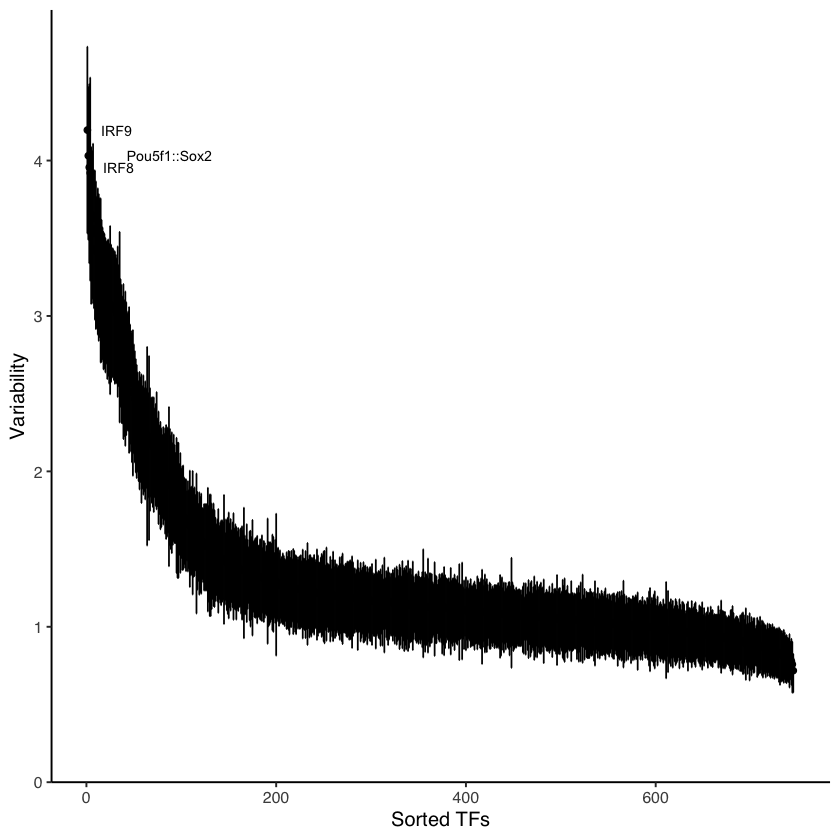

In [10]:
variability <- computeVariability(dev)

plotVariability(variability, use_plotly = FALSE) 

In [13]:
head(variability)

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0004.1.Arnt,Arnt,1.3097587,1.0574367,1.539051,1.354635e-03,5.368102e-03
MA0006.1.Ahr::Arnt,Ahr::Arnt,1.6408099,1.3310370,1.897313,1.558287e-09,1.055386e-08
MA0019.1.Ddit3::Cebpa,Ddit3::Cebpa,0.9217392,0.7530152,1.071486,7.633490e-01,8.387992e-01
MA0029.1.Mecom,Mecom,1.1118984,0.9152195,1.279191,1.241110e-01,2.357689e-01
MA0030.1.FOXF2,FOXF2,1.2476069,0.9803963,1.488305,7.572098e-03,2.648457e-02
MA0031.1.FOXD1,FOXD1,1.4145492,1.1059477,1.689789,4.012849e-05,2.019982e-04


Let's save the final results so we can compare it with pychromVAR

In [8]:
df_z <- as.data.frame(t(round(assays(dev)$z, 2)))
write.csv(df_z, "chromvar_z.csv")

We also save the count matrix so we can use it as input for pychromVAR

In [9]:
counts <- assays(example_counts)$counts
rownames(counts) <- df_peaks$peak
counts <- as.data.frame(as.matrix(counts))
write.csv(counts, "counts.csv")